In [1]:
import os
import gc
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22"))

In [3]:
valid_period[1]-valid_period[0]

Timedelta('27 days 00:00:00')

***
# Level 1

In [4]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )
data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)

data.sort_values(["ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

scale_factor = np.sqrt(np.nanmean(data.y.diff(1)**2))
scale_factor

remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

***

In [5]:
model_params = {
    'objective': 'l2', 
    'metric': 'rmse', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'learning_rate': 0.28543912663785515, 
    'num_leaves': 10, 
    'max_bin': 123, 
    'feature_fraction': 0.7000000000000001, 
    'bagging_fraction': 0.8, 
    'min_data_in_leaf': 5, 
    'min_gain_to_split': 100000, 
    'lambda_l2': 0.6845940785471598, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{"event_name_1":"default"},
    "copy":True,
}

In [6]:
# 4+ years of history
train_history = 1800

############################################### 1/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 979.52it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3186.52
[50]	valid_0's rmse: 3296.2
[75]	valid_0's rmse: 3634.27
[100]	valid_0's rmse: 3671.02
[125]	valid_0's rmse: 3593.4
[150]	valid_0's rmse: 3584.72
[175]	valid_0's rmse: 3560.91
[200]	valid_0's rmse: 3541.63
[225]	valid_0's rmse: 3541.17
[250]	valid_0's rmse: 3495.39
[275]	valid_0's rmse: 3578.13
[300]	valid_0's rmse: 3568.58
Early stopping, best iteration is:
[9]	valid_0's rmse: 2918.98
RMSE: 2918.977699138606
RMSSE: 0.4916750969510031


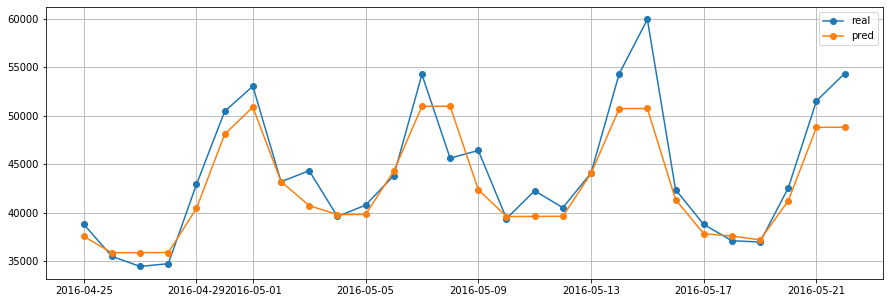

############################################### 2/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2004.93it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2582.35
[50]	valid_0's rmse: 2611.84
[75]	valid_0's rmse: 2637.83
[100]	valid_0's rmse: 2647.86
[125]	valid_0's rmse: 2580.2
[150]	valid_0's rmse: 2617.89
[175]	valid_0's rmse: 2629.65
[200]	valid_0's rmse: 2657.84
[225]	valid_0's rmse: 2650.33
[250]	valid_0's rmse: 2641.68
[275]	valid_0's rmse: 2629.55
[300]	valid_0's rmse: 2666.24
[325]	valid_0's rmse: 2638.04
Early stopping, best iteration is:
[32]	valid_0's rmse: 2500.41
RMSE: 2500.4108486411515
RMSSE: 0.42117133912526034


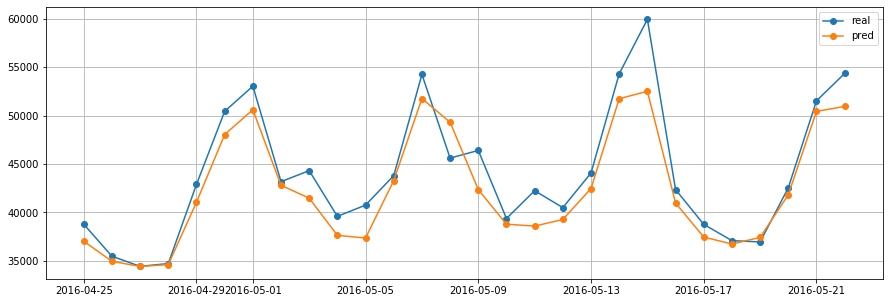

############################################### 3/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1735.33it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3230.19
[50]	valid_0's rmse: 3298.53
[75]	valid_0's rmse: 3285.38
[100]	valid_0's rmse: 3360
[125]	valid_0's rmse: 3281.88
[150]	valid_0's rmse: 3394.22
[175]	valid_0's rmse: 3344.88
[200]	valid_0's rmse: 3224.3
[225]	valid_0's rmse: 3260.8
[250]	valid_0's rmse: 3217.13
[275]	valid_0's rmse: 3202.23
[300]	valid_0's rmse: 3243.81
Early stopping, best iteration is:
[15]	valid_0's rmse: 3086.45
RMSE: 3086.447254635616
RMSSE: 0.5198838119266717


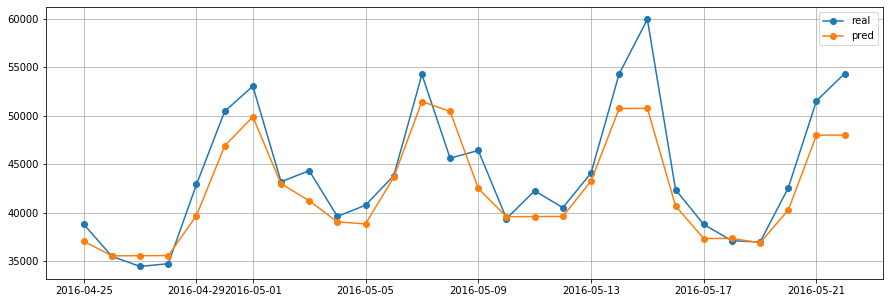

############################################### 4/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2107.69it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3060.12
[50]	valid_0's rmse: 3088.42
[75]	valid_0's rmse: 3134.12
[100]	valid_0's rmse: 3132.95
[125]	valid_0's rmse: 3115.25
[150]	valid_0's rmse: 3072.66
[175]	valid_0's rmse: 3128.58
[200]	valid_0's rmse: 3134.18
[225]	valid_0's rmse: 3135.79
[250]	valid_0's rmse: 3133.86
[275]	valid_0's rmse: 3122.22
[300]	valid_0's rmse: 3120.74
[325]	valid_0's rmse: 3083.19
Early stopping, best iteration is:
[32]	valid_0's rmse: 2965.36
RMSE: 2965.364772063213
RMSSE: 0.49948857513694805


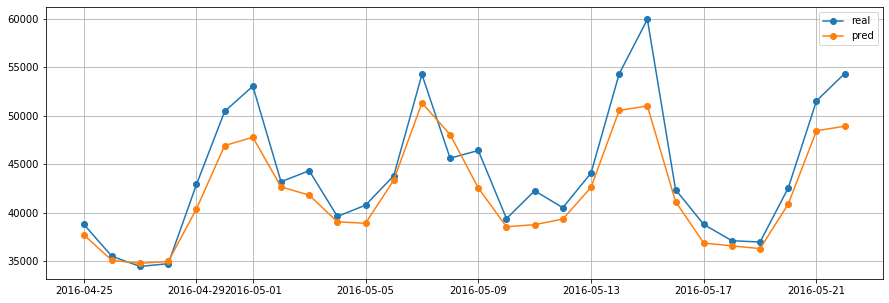

############################################### 5/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2110.87it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2807.99
[50]	valid_0's rmse: 3010.2
[75]	valid_0's rmse: 3004.27
[100]	valid_0's rmse: 2968.57
[125]	valid_0's rmse: 2800.2
[150]	valid_0's rmse: 2920.6
[175]	valid_0's rmse: 2906.69
[200]	valid_0's rmse: 2950.12
[225]	valid_0's rmse: 2966.96
[250]	valid_0's rmse: 2928.32
[275]	valid_0's rmse: 2951.29
[300]	valid_0's rmse: 2931.05
Early stopping, best iteration is:
[14]	valid_0's rmse: 2658.61
RMSE: 2658.6073852441386
RMSSE: 0.44781809887766955


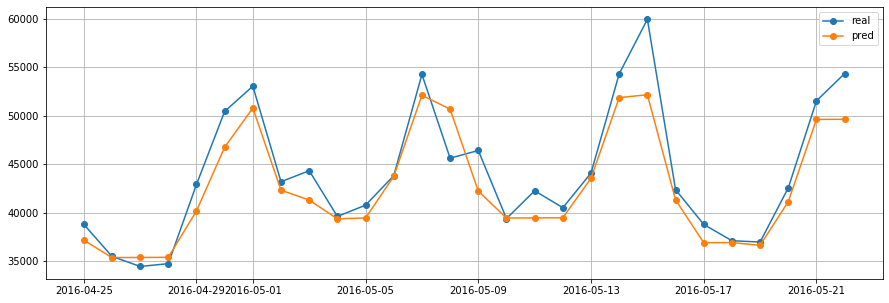

############################################### 6/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2204.05it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3100.43
[50]	valid_0's rmse: 2956.46
[75]	valid_0's rmse: 2945.49
[100]	valid_0's rmse: 2902.31
[125]	valid_0's rmse: 2978.81
[150]	valid_0's rmse: 2937.1
[175]	valid_0's rmse: 2973.47
[200]	valid_0's rmse: 2911.85
[225]	valid_0's rmse: 2864.13
[250]	valid_0's rmse: 2949.7
[275]	valid_0's rmse: 2898.1
[300]	valid_0's rmse: 2954.15
[325]	valid_0's rmse: 2891.32
[350]	valid_0's rmse: 2866.11
[375]	valid_0's rmse: 2853.28
[400]	valid_0's rmse: 2836.71
[425]	valid_0's rmse: 2826.55
[450]	valid_0's rmse: 2796.91
[475]	valid_0's rmse: 2797.82
[500]	valid_0's rmse: 2793.61
[525]	valid_0's rmse: 2792.52
[550]	valid_0's rmse: 2784.76
[575]	valid_0's rmse: 2804.89
[600]	valid_0's rmse: 2800.04
[625]	valid_0's rmse: 2835.28
[650]	valid_0's rmse: 2807.18
[675]	valid_0's rmse: 2815.84
[700]	valid_0's rmse: 2817.95
[725]	valid_0's rmse: 2824.91
[750]	valid_0's rmse: 2829.82
Early stopping, best iteration is:
[462]	val

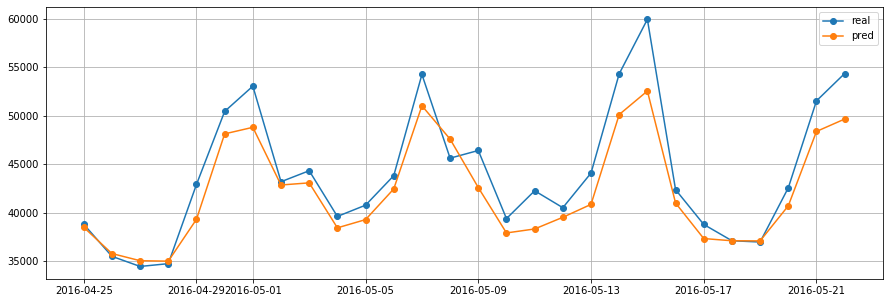

############################################### 7/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2069.22it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2824.81
[50]	valid_0's rmse: 2946.35
[75]	valid_0's rmse: 3080.63
[100]	valid_0's rmse: 2927.44
[125]	valid_0's rmse: 2869.51
[150]	valid_0's rmse: 2845.95
[175]	valid_0's rmse: 2879.72
[200]	valid_0's rmse: 2893.8
[225]	valid_0's rmse: 2926.32
[250]	valid_0's rmse: 2858.6
[275]	valid_0's rmse: 2869.99
[300]	valid_0's rmse: 2879.43
[325]	valid_0's rmse: 2876.59
Early stopping, best iteration is:
[33]	valid_0's rmse: 2795.09
RMSE: 2795.0936416627433
RMSSE: 0.47080796049151474


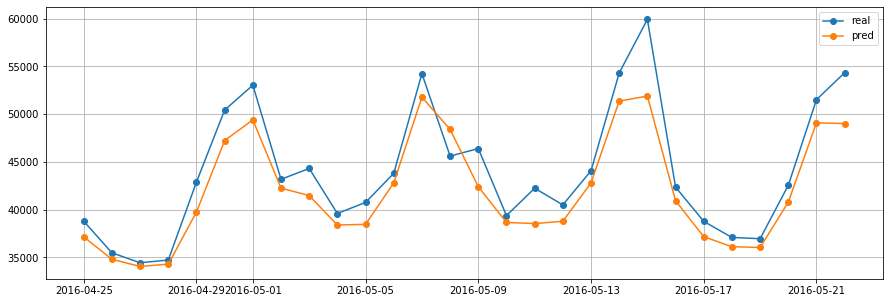

############################################### 8/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1565.62it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2912.71
[50]	valid_0's rmse: 3158.57
[75]	valid_0's rmse: 3128.63
[100]	valid_0's rmse: 3173.43
[125]	valid_0's rmse: 3112.19
[150]	valid_0's rmse: 3072.1
[175]	valid_0's rmse: 3100.06
[200]	valid_0's rmse: 3030.08
[225]	valid_0's rmse: 3011.77
[250]	valid_0's rmse: 3035.42
[275]	valid_0's rmse: 3066.73
[300]	valid_0's rmse: 3076.32
[325]	valid_0's rmse: 3111.06
Early stopping, best iteration is:
[27]	valid_0's rmse: 2883.72
RMSE: 2883.7224990494014
RMSSE: 0.4857366809339838


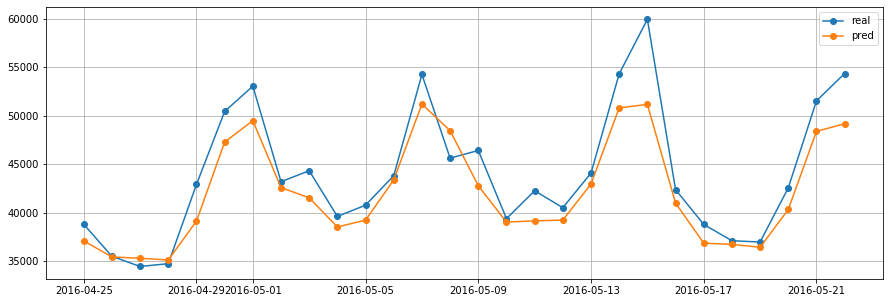

############################################### 9/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2043.01it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3114.52
[50]	valid_0's rmse: 3088.97
[75]	valid_0's rmse: 3105.61
[100]	valid_0's rmse: 3205.75
[125]	valid_0's rmse: 3225.51
[150]	valid_0's rmse: 3191.69
[175]	valid_0's rmse: 3339.62
[200]	valid_0's rmse: 3343.1
[225]	valid_0's rmse: 3267.28
[250]	valid_0's rmse: 3248.41
[275]	valid_0's rmse: 3198.96
[300]	valid_0's rmse: 3209.1
[325]	valid_0's rmse: 3140
Early stopping, best iteration is:
[42]	valid_0's rmse: 3016.94
RMSE: 3016.940322276144
RMSSE: 0.5081760048691887


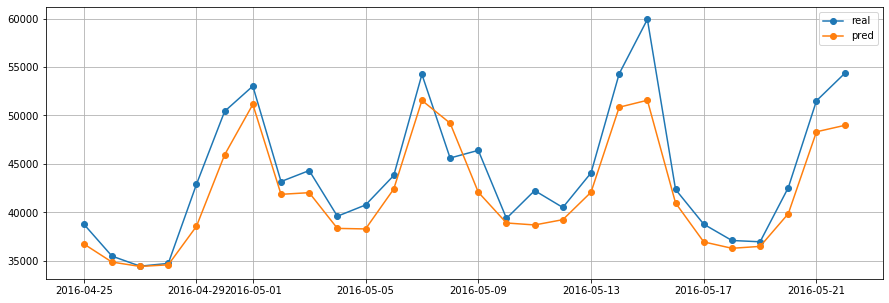

############################################## 10/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2212.19it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3157.4
[50]	valid_0's rmse: 3012.43
[75]	valid_0's rmse: 3079.07
[100]	valid_0's rmse: 3099.86
[125]	valid_0's rmse: 3172.73
[150]	valid_0's rmse: 3221.4
[175]	valid_0's rmse: 3190.39
[200]	valid_0's rmse: 3101.99
[225]	valid_0's rmse: 3084.22
[250]	valid_0's rmse: 3117.14
[275]	valid_0's rmse: 3116.6
[300]	valid_0's rmse: 3116.78
[325]	valid_0's rmse: 3107.18
Early stopping, best iteration is:
[49]	valid_0's rmse: 2985.94
RMSE: 2985.9440651706896
RMSSE: 0.5029549688462208


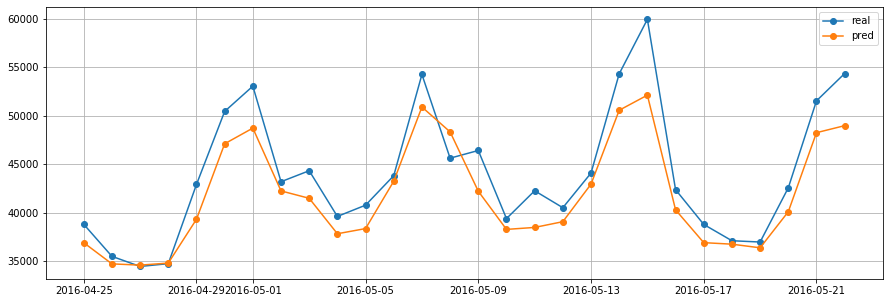

############################################## 11/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1731.04it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2952.95
[50]	valid_0's rmse: 2848.5
[75]	valid_0's rmse: 2919.35
[100]	valid_0's rmse: 2830.27
[125]	valid_0's rmse: 2821.82
[150]	valid_0's rmse: 2768.39
[175]	valid_0's rmse: 2796.95
[200]	valid_0's rmse: 2803.12
[225]	valid_0's rmse: 2780.19
[250]	valid_0's rmse: 2773.88
[275]	valid_0's rmse: 2779.26
[300]	valid_0's rmse: 2783.54
[325]	valid_0's rmse: 2755.3
[350]	valid_0's rmse: 2821.59
[375]	valid_0's rmse: 2820.68
[400]	valid_0's rmse: 2850.44
[425]	valid_0's rmse: 2787.07
[450]	valid_0's rmse: 2768.18
[475]	valid_0's rmse: 2781.06
[500]	valid_0's rmse: 2785.89
[525]	valid_0's rmse: 2775.68
[550]	valid_0's rmse: 2764.98
[575]	valid_0's rmse: 2741.27
Early stopping, best iteration is:
[288]	valid_0's rmse: 2708.87
RMSE: 2708.868449103227
RMSSE: 0.4562841154056719


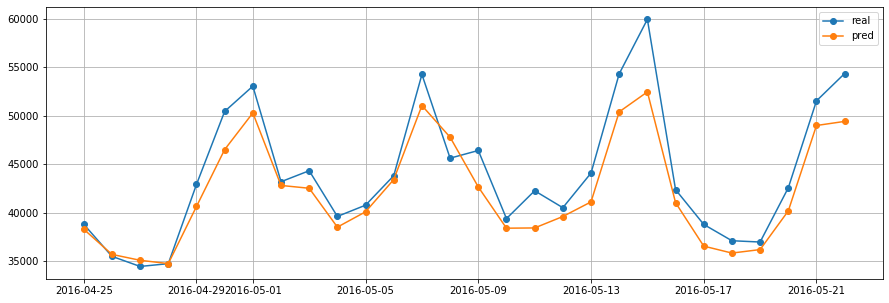

############################################## 12/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1478.43it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3112.79
[50]	valid_0's rmse: 3161.73
[75]	valid_0's rmse: 3216.55
[100]	valid_0's rmse: 3238.1
[125]	valid_0's rmse: 3128.5
[150]	valid_0's rmse: 3071.64
[175]	valid_0's rmse: 3010.73
[200]	valid_0's rmse: 2969.61
[225]	valid_0's rmse: 2974.99
[250]	valid_0's rmse: 2927.69
[275]	valid_0's rmse: 2966.13
[300]	valid_0's rmse: 3022.19
[325]	valid_0's rmse: 3048.64
[350]	valid_0's rmse: 3119.74
[375]	valid_0's rmse: 3113.81
[400]	valid_0's rmse: 3102.23
[425]	valid_0's rmse: 3071.71
[450]	valid_0's rmse: 3079.74
[475]	valid_0's rmse: 3086.31
[500]	valid_0's rmse: 3051.88
[525]	valid_0's rmse: 3008.45
[550]	valid_0's rmse: 3050.67
Early stopping, best iteration is:
[255]	valid_0's rmse: 2918.09
RMSE: 2918.0944554905077
RMSSE: 0.49152632263647567


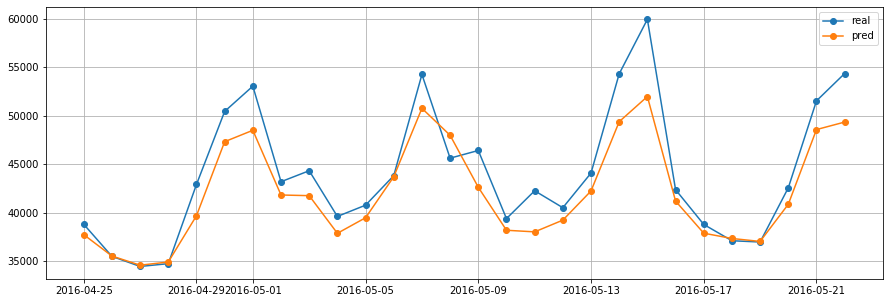

############################################## 13/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2077.42it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3162.67
[50]	valid_0's rmse: 3106.67
[75]	valid_0's rmse: 3075.43
[100]	valid_0's rmse: 3185.15
[125]	valid_0's rmse: 3152.7
[150]	valid_0's rmse: 3171.37
[175]	valid_0's rmse: 3186.67
[200]	valid_0's rmse: 3232.14
[225]	valid_0's rmse: 3244.5
[250]	valid_0's rmse: 3230.49
[275]	valid_0's rmse: 3191.87
[300]	valid_0's rmse: 3211.89
Early stopping, best iteration is:
[17]	valid_0's rmse: 2892.81
RMSE: 2892.8111256390193
RMSSE: 0.4872675769599865


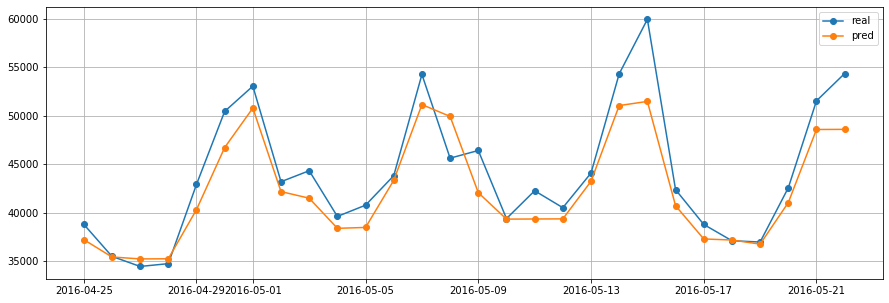

############################################## 14/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1820.44it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 3054.46
[50]	valid_0's rmse: 3150.84
[75]	valid_0's rmse: 3195.13
[100]	valid_0's rmse: 3105.43
[125]	valid_0's rmse: 3120.01
[150]	valid_0's rmse: 3153.54
[175]	valid_0's rmse: 3094.36
[200]	valid_0's rmse: 3169.9
[225]	valid_0's rmse: 3190.57
[250]	valid_0's rmse: 3202.88
[275]	valid_0's rmse: 3271.4
[300]	valid_0's rmse: 3146.5
[325]	valid_0's rmse: 3166.98
[350]	valid_0's rmse: 3156.12
[375]	valid_0's rmse: 3169.55
Early stopping, best iteration is:
[84]	valid_0's rmse: 3021.74
RMSE: 3021.7376864464513
RMSSE: 0.5089840769878079


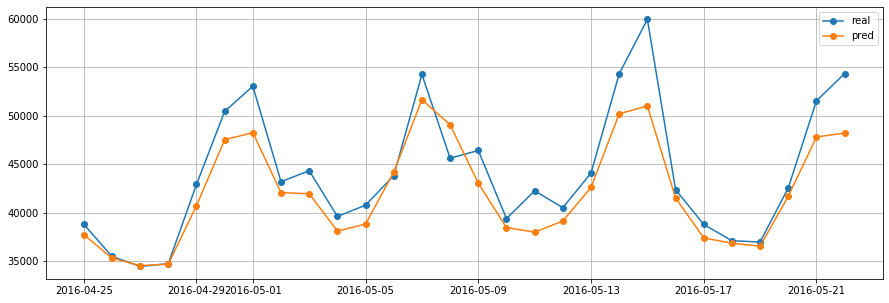

############################################## 15/20 ###############################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1071.34it/s]


In [ ]:
errors = list()
best_iterations = list()
models_level1 = list()

for i,seed in enumerate(SEEDS):
    print(f" {i+1}/{len(SEEDS)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)   
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(_train_data, _valid_index)
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);    
    _fcaster.fit(fit_kwargs={"verbose_eval":25})
    models_level1.append(_fcaster)

    errors.append(_fcaster.model.model.best_score["valid_0"]["rmse"]/scale_factor)
    best_iterations.append(_fcaster.best_iteration)

    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])    
    predictions = pd.merge(predictions,
                           _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
                           how="inner", 
                           on=["ds"]).rename({"y_raw":"y"}, axis=1)
    
    print(f"RMSE: {errors[-1]*scale_factor}")
    print(f"RMSSE: {errors[-1]}")
    plt.figure(figsize=(15,5))
    plt.plot_date(predictions.ds, predictions.y, "o-", label="real")
    plt.plot_date(predictions.ds, predictions.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
all_predictions = [_fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")]) for _fcaster in models_level1]

forecast_level1 = all_predictions[0].copy(deep=True)
forecast_level1["y_pred"] = np.mean([_prediction.y_pred.values for _prediction in all_predictions], axis=0)

mrg = pd.merge(forecast_level1,
               _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
               how="inner", 
               on=["ds"])
rmse = compute_rmse(mrg.y_raw.values, mrg.y_pred.values)
rmsse = rmse/scale_factor
print(f"rmse: {rmse}")
print(f"rmsse: {rmsse}")

plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y_raw, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
del data
gc.collect()

***
# Level 2

In [ ]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["state_id","ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["state_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

weights_level2 = pd.read_parquet("../input/weights_level2.parquet")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level2 = compute_scaling(scaling_input, agg_columns=["state_id"]).rename({"q":"s"}, axis=1)

# outlier removal
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

In [ ]:
model_params = {
    'objective': 'l2', 
    'metric': 'None', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'num_threads': 10, 
    'learning_rate': 0.2893587542945107, 
    'num_leaves': 12, 
    'max_bin': 97, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.8, 
    'min_data_in_leaf': 11, 
    'min_gain_to_split': 100, 
    'lambda_l2': 5.781131218800134, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "state_id":"default",
        "event_name_1":"default"},
    "ts_uid_columns":["state_id"],
    
}

In [ ]:
# 4+ years of history
train_history = 1800

In [ ]:
errors = list()
best_iterations = list()

models_level2 = list()

for i,seed in enumerate(SEEDS):
    print(f" {i+1}/{len(SEEDS)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)   
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(_train_data, ts_uid_columns=["state_id"])
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = _WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level2, 
                                scales_level2,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    models_level2.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

In [ ]:
all_predictions = [_fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")]) for _fcaster in models_level2]
forecast_level2 = all_predictions[0].copy(deep=True)
forecast_level2["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

In [ ]:
mrg = pd.merge(forecast_level2,
               _fcaster.valid_features.loc[:, ["ds","state_id","y_raw"]], 
               how="inner", 
               on=["ds","state_id"])

mrg["sq_error"] = mrg.eval("(y_raw-y_pred)**2")

rmsse = (mrg
         .groupby(["state_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level2, how="left", on=["state_id"])
         .merge(weights_level2, how="left", on=["state_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

In [ ]:
for state_id in [1,2,3]:    
    df_cut = mrg.query("state_id == @state_id")
    rmsse = np.sqrt(df_cut.eval("(y_raw-y_pred)**2").mean()) / scales_level2.query("state_id == @state_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"state_id: {state_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y_raw, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
# Level 3

In [ ]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["store_id","ds"])
        .agg({"q":"sum",
              "state_id":lambda x: int(x.unique()),
              "snap":lambda x: int(x.unique()),
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["store_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

weights_level3 = pd.read_parquet("../input/weights_level3.parquet")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level3 = compute_scaling(scaling_input, agg_columns=["store_id"]).rename({"q":"s"}, axis=1)

# outlier removal
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

In [ ]:
model_params = {
    'objective': 'l2', 
    'metric': 'None', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'num_threads': 10, 
    'learning_rate': 0.29527215922256966, 
    'num_leaves': 31, 'max_bin': 163, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.6000000000000001, 
    'min_data_in_leaf': 24, 
    'min_gain_to_split': 1, 
    'lambda_l2': 0.504534786307544, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "store_id":"default",
        "state_id":"default",
        "event_name_1":"default",
        "snap":"default"},
    "ts_uid_columns":["store_id"],  
}

In [ ]:
# 4+ years of history
train_history = 1800

In [ ]:
errors = list()
best_iterations = list()

models_level3 = list()

for i,seed in enumerate(SEEDS):
    print(f" {i+1}/{len(SEEDS)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)   
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(_train_data, ts_uid_columns=["store_id"])
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = _WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                 weights_level3, 
                                 scales_level3,
                                 ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    models_level3.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

In [ ]:
all_predictions = [_fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")]) for _fcaster in models_level3]
forecast_level3 = all_predictions[0].copy(deep=True)
forecast_level3["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

In [ ]:
mrg = pd.merge(forecast_level3,
               _fcaster.valid_features.loc[:, ["ds","store_id","y_raw"]], 
               how="inner", 
               on=["ds","store_id"])

mrg["sq_error"] = mrg.eval("(y_raw-y_pred)**2")

rmsse = (mrg
         .groupby(["store_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level3, how="left", on=["store_id"])
         .merge(weights_level3, how="left", on=["store_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

In [ ]:
for store_id in range(1,11): 
    df_cut = mrg.query("store_id == @store_id")
    rmsse = np.sqrt(df_cut.eval("(y_raw-y_pred)**2").mean()) / scales_level3.query("store_id == @store_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"store_id: {store_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y_raw, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
# Level 12

In [ ]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [ ]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level12 = compute_scaling(scaling_input, agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

In [ ]:
# outlier removal
#remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
#data.drop(remove_idx, axis=0, inplace=True)

In [ ]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
                    #"n_prices",
                    #"price_iqr1",
                    #"price_iqr2",
                    #"price_min",
                    #"price_max",
                    #"price_momentum_q",
                    #"price_momentum_s",
                    "ts_id",
                    "event_type_1",
                    "event_name_2",
                    "event_type_2"]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "lags": list(range(1,15)),
    "window_shifts":[1,7,28],
    "window_functions":["mean","std"],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

In [ ]:
%%time

## VALIDATION MODEL

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds <= @valid_end").reset_index(drop=True)
_valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
model_level12.train_features.dropna(inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)

# needed to remove leakage of 'no_stock' feature
no_stock_ts = list()
for threshold in [28, 56, 84, 112, 140, 168]:
    left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
    no_stock_ts.append((model_level12.train_features
                        .query("ds >= @left_date")
                        .groupby(["ts_id"])
                        .filter(lambda x: np.all(x.y==0))
                        .loc[:, ["ts_id"]]
                        .drop_duplicates()))
model_level12.valid_features["no_stock"] = 0
for j,no_stock in enumerate(no_stock_ts):
    idx = model_level12.valid_features.query("ts_id in @no_stock.ts_id").index
    model_level12.valid_features.loc[idx, "no_stock"] = j+1

evaluator = Evaluator(model_level12.valid_features)
model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

# visualizing the predictions at level 1
predictions = (model_level12.valid_features
               .loc[:, ["ds"]+model_level12.ts_uid_columns]
               .assign(y_pred = model_level12.model.predict(model_level12.valid_features))
              )
mrg =  (data.loc[:, ["ds","item_id","store_id","y"]]
        .merge(predictions, how="inner", on=["ds","item_id","store_id"]))
df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()

print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

In [ ]:
evaluator.eval2.errors_by_level

In [ ]:
del model_level12, _train_data, _valid_index, evaluator
gc.collect()

***

In [ ]:
model_kwargs["model_params"]["num_iterations"] = 802
model_kwargs["model_params"]

In [ ]:
%%time

### REAL MODEL
print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
_train_data = data.query("ds < @valid_start").reset_index(drop=True)

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data);
model_level12.train_features.dropna(inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.fit()

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

In [ ]:
valid_data = data.query("@valid_period[0] <= ds <= @valid_period[1]").copy()
valid_data.drop("y", axis=1, inplace=True)

# needed to remove leakage of 'no_stock' feature
no_stock_ts = list()
for threshold in [28, 56, 84, 112, 140, 168]:
    left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
    no_stock_ts.append((model_level12.train_features
                        .query("ds >= @left_date")
                        .groupby(["ts_id"])
                        .filter(lambda x: np.all(x.y==0))
                        .loc[:, ["ts_id"]]
                        .drop_duplicates()))
    
valid_data["no_stock"] = 0
for j,no_stock in enumerate(no_stock_ts):
    idx = valid_data.query("ts_id in @no_stock.ts_id").index
    valid_data.loc[idx, "no_stock"] = j+1
    
# removes ts_id without training data
ts_id_in_train = set(model_level12.train_features.ts_id)
valid_data = valid_data.query("ts_id in @ts_id_in_train")

In [ ]:
%%time
def bias_corr_func(x):
    x[x < 0.1] = 0
    return x

forecast_level12 = model_level12.predict(valid_data, recursive=True, bias_corr_func=bias_corr_func);

In [ ]:
# hasta aqui se corrio la wea

***

In [123]:
valid_data = data.query("@valid_period[0] <= ds <= @valid_period[1]").copy()
valid_data = valid_data.query("ts_id in @ts_id_in_train")
valid_dataframe = valid_data.loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
evaluator = WRMSSEEvaluator(valid_dataframe)

In [124]:
evaluator._evaluate(valid_dataframe.merge(forecast_level12, how="left", on=["ds","item_id","store_id"]).y_pred.values)

0.48378650297793246

In [125]:
evaluator.errors_by_level

{'root': 0.1858710079815111,
 ('state_id',): 0.29718166691914855,
 ('store_id',): 0.3803760084596124,
 ('cat_id',): 0.2605638535324318,
 ('dept_id',): 0.3909988956511012,
 ('state_id', 'cat_id'): 0.36828245598050113,
 ('state_id', 'dept_id'): 0.47544100693825847,
 ('store_id', 'cat_id'): 0.4561343972317963,
 ('store_id', 'dept_id'): 0.558425132389371,
 ('item_id',): 0.7966635854554946,
 ('item_id', 'state_id'): 0.8132827802907246,
 ('item_id', 'store_id'): 0.8222172449052387}

In [126]:
mrg = pd.merge(forecast_level12,
               data.query("@valid_period[0] <= ds <= @valid_period[1]").loc[:, ["ds","item_id","store_id","y"]],
               how="inner", on=["ds","item_id","store_id"])

In [127]:
mrg["sq_error"] = mrg.eval("(y-y_pred)**2")

rmsse = (mrg
         .groupby(["store_id","item_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level12, how="left", on=["store_id","item_id"])
         .merge(weights_level12, how="left", on=["store_id","item_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse L12:", rmsse)

rmsse L12: 0.8222172449052388


***
#### Error of level 12 predictions at level 1

RMSE: 1101.4739560968724
RMSSE: 0.18587100835893794


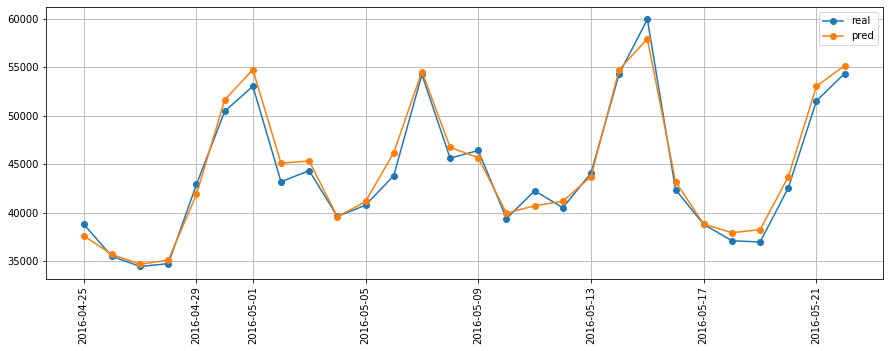

In [128]:
df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()

print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

***
#### Error of level 12 predictions at level 2

In [129]:
org = data.loc[:, ["store_id","state_id"]].drop_duplicates()

In [130]:
df = (mrg
      .merge(org, how="left")
      .groupby(["ds","state_id"])["y","y_pred"]
      .sum()
      .reset_index())

In [131]:
df["sq_error"] = df.eval("(y-y_pred)**2")

rmsse = (df
         .groupby(["state_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level2, how="left", on=["state_id"])
         .merge(weights_level2, how="left", on=["state_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.29718166691914855


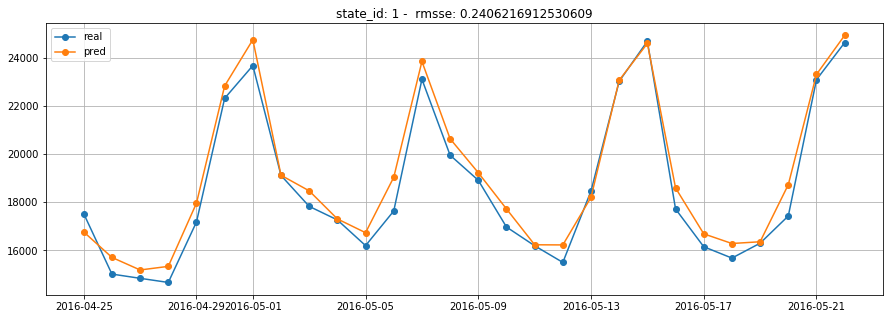

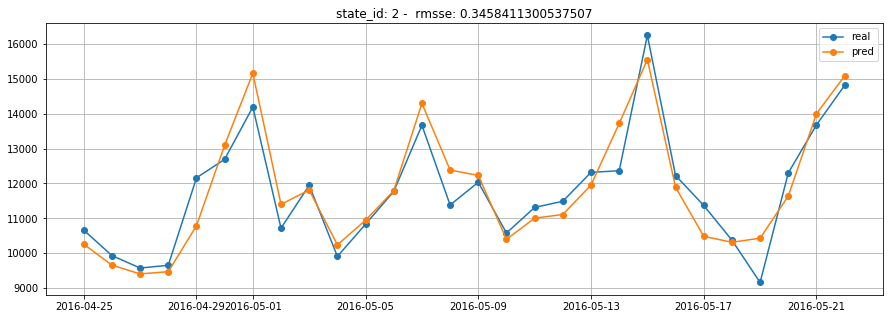

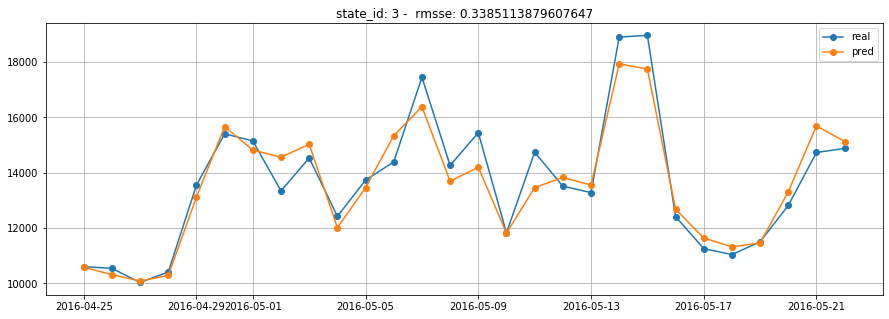

In [132]:
for state_id in [1,2,3]:    
    df_cut = df.query("state_id == @state_id")
    rmsse = np.sqrt(df_cut.eval("(y-y_pred)**2").mean()) / scales_level2.query("state_id == @state_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"state_id: {state_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
#### Error of level 12 predictions at level 3

In [133]:
df = (mrg
      .groupby(["ds","store_id"])["y","y_pred"]
      .sum()
      .reset_index())

In [134]:
df["sq_error"] = df.eval("(y-y_pred)**2")

rmsse = (df
         .groupby(["store_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level3, how="left", on=["store_id"])
         .merge(weights_level3, how="left", on=["store_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.3803760084596124


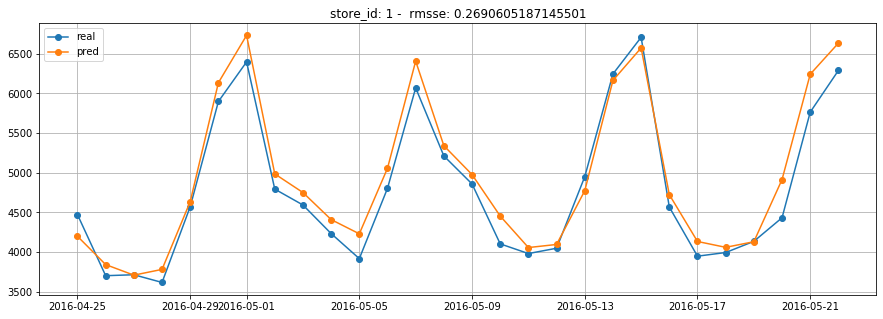

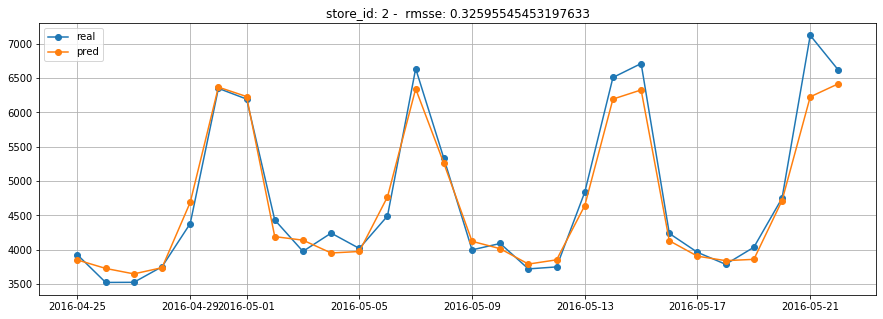

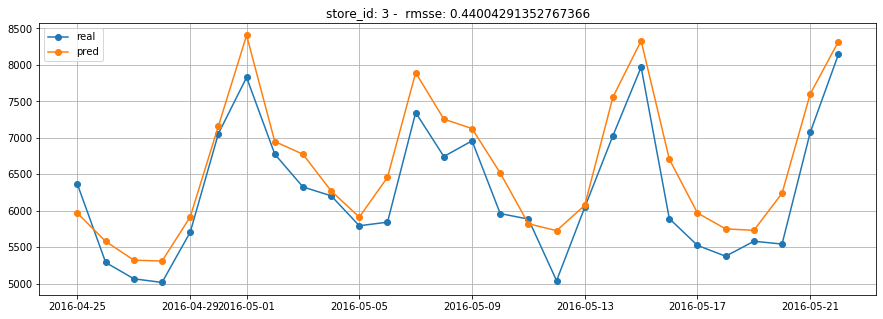

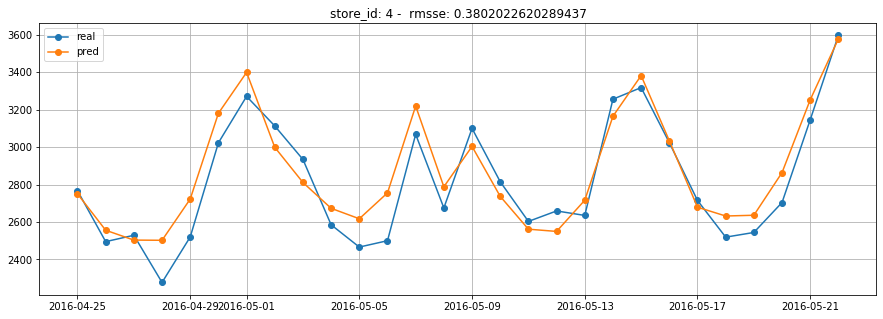

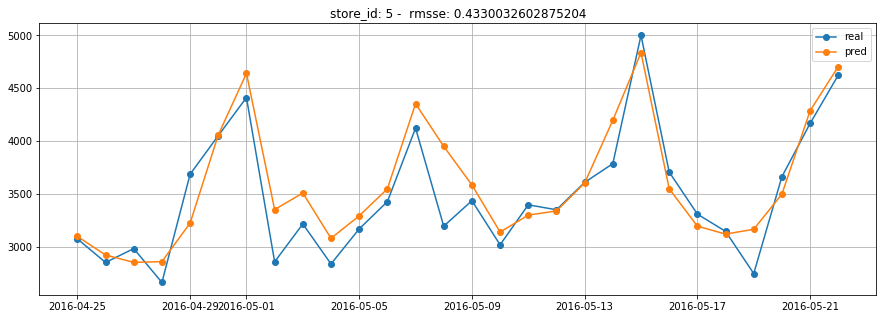

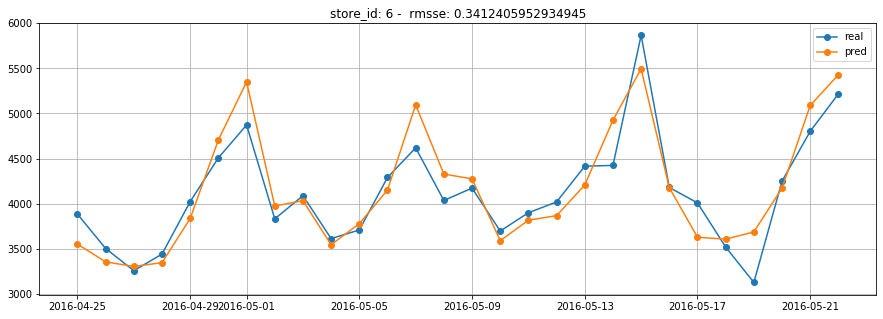

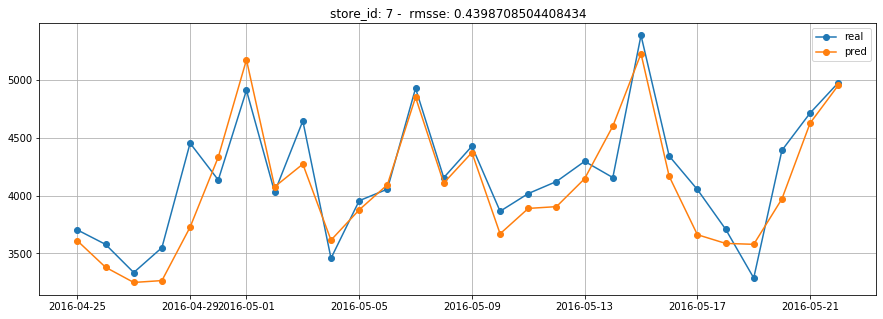

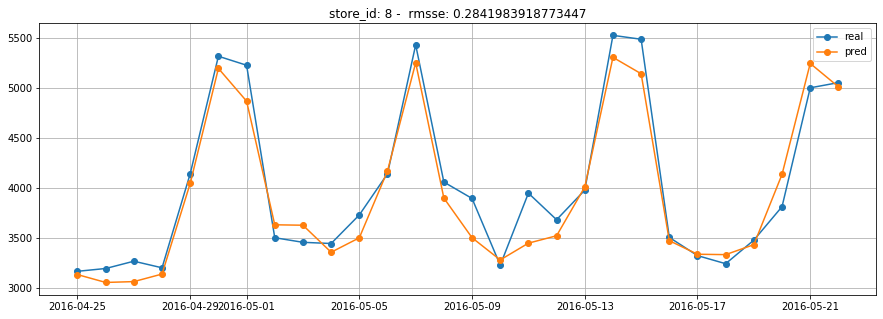

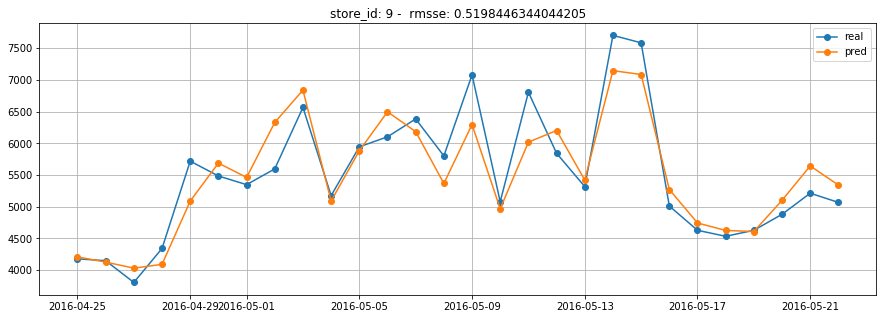

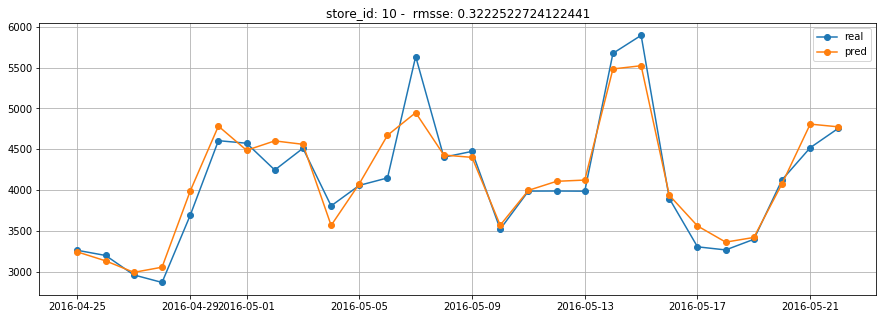

In [135]:
for store_id in range(1,11): 
    df_cut = df.query("store_id == @store_id")
    rmsse = np.sqrt(df_cut.eval("(y-y_pred)**2").mean()) / scales_level3.query("store_id == @store_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"store_id: {store_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
### storing the resulting forecast

In [137]:
#forecast_level1.to_csv("../output/forecast_level1_hts.csv", index=False)
#forecast_level2.to_csv("../output/forecast_level2_hts.csv", index=False)
#forecast_level3.to_csv("../output/forecast_level3_hts.csv", index=False)
#forecast_level12.to_csv("../output/forecast_level12_hts.csv", index=False)

***
# HTS distribution

In [57]:
import pickle
from mahts import HTSDistributor

In [58]:
hierarchy = pd.read_parquet("../input/hierarchy_raw.parquet")

infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

***

In [152]:
fcst_l01 = (
    forecast_level1
    .set_index("ds")
    .rename({"y_pred":"root"}, axis=1)
)
fcst_l01.head()

,root
ds,
2016-03-28,36935.513237
2016-03-29,34720.551276
2016-03-30,34358.391816
2016-03-31,35395.477961
2016-04-01,44975.848990


In [153]:
fcst_l02 = (
    forecast_level2
    .assign(state_id = lambda x: encoders["state"].inverse_transform(x.state_id))
    .pivot(index="ds", columns="state_id", values="y_pred")
)
fcst_l02.head()

state_id,CA,TX,WI
ds,,,
2016-03-28,16535.371986,10197.842736,10502.718106
2016-03-29,15386.248188,9446.751373,10149.642743
2016-03-30,15333.717662,9361.121127,10330.725099
2016-03-31,15854.151610,9736.475264,11145.065664
2016-04-01,19399.558621,12701.199478,14145.093594


In [154]:
fcst_l03 = (
    forecast_level3
    .assign(store_id = lambda x: encoders["store"].inverse_transform(x.store_id))
    .pivot(index="ds", columns="store_id", values="y_pred")
)
fcst_l03.head()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
ds,,,,,,,,,,
2016-03-28,3993.527949,3874.561488,5867.515750,2487.967674,2866.923592,3638.354240,3545.228441,3186.701875,4272.072744,3101.520932
2016-03-29,3600.007062,3740.084198,5423.122889,2335.003783,2698.731702,3361.260494,3315.672360,3138.071653,4188.675666,2978.334505
2016-03-30,3593.246380,3749.754879,5358.009889,2330.084366,2686.578282,3360.259149,3297.906804,3184.365921,4231.041652,2986.477512
2016-03-31,3679.753807,3827.532894,5417.604606,2359.686297,2712.420807,3408.785893,3327.507357,3317.223659,4376.681181,3113.472217
2016-04-01,4973.562554,4688.520043,6783.916213,2820.001069,3554.737962,4419.608472,4246.031365,4098.176337,5366.115118,4139.815982


In [155]:
fcst_l12 = (
    forecast_level12
    .assign(item_id = lambda x: encoders["item"].inverse_transform(x.item_id))
    .assign(store_id = lambda x: encoders["store"].inverse_transform(x.store_id))
    .merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left", on=["item_id","store_id"])
    .drop(["item_id","store_id"], axis=1)
    .pivot(index="ds", columns="id", values="y_pred")
)
fcst_l12.head()

id,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,FOODS_1_001_WI_3,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2016-03-28,0.613822,0.939573,0.776135,0.501383,0.514565,0.581340,0.334217,0.391897,0.372297,0.260367,...,0.217431,0.174954,0.138966,0.156687,0.195924,0.283586,0.134742,0.099421,0.143297,0.172828
2016-03-29,0.662111,0.736928,1.285963,0.434554,0.490593,0.543546,0.287590,0.377370,0.346454,0.210805,...,0.185395,0.164342,0.131381,0.091499,0.178868,0.246645,0.192457,0.151648,0.089254,0.144000
2016-03-30,0.696779,0.702484,1.282712,0.468232,0.514744,0.478443,0.285358,0.411409,0.374456,0.353776,...,0.182759,0.176311,0.132005,0.148806,0.184346,0.245034,0.188285,0.138205,0.095470,0.139402
2016-03-31,0.755014,0.794291,1.125685,0.471394,0.498905,0.713100,0.295962,0.352177,0.373441,0.319521,...,0.177588,0.137625,0.142252,0.144525,0.163068,0.242019,0.237027,0.136731,0.101636,0.141925
2016-04-01,0.965814,1.086431,1.304410,0.394096,0.661928,0.802171,0.413251,0.435564,0.455466,0.384625,...,0.214645,0.181682,0.177358,0.138513,0.166713,0.297297,0.282284,0.153718,0.122601,0.168927


In [162]:
hierarchy_dict = {"root":fcst_l12.columns}

#hierarchy_dict = {"root":hierarchy.state_id.unique()}

#for state_id in hierarchy.state_id.unique():
#    hierarchy_dict[state_id] = hierarchy.query("state_id == @state_id").store_id.unique()
    
#for store_id in hierarchy.store_id.unique():
#    hierarchy_dict[store_id] = hierarchy.query("store_id == @store_id & id in @fcst_l12.columns").id.unique()

In [163]:
%%time
hts = HTSDistributor(hierarchy_dict)

CPU times: user 4min 21s, sys: 31.7 s, total: 4min 52s
Wall time: 4min 52s


In [169]:
#fcst_all_levels = pd.concat([fcst_l01, fcst_l02, fcst_l03, fcst_l12], axis=1)
fcst_all_levels = pd.concat([fcst_l01, fcst_l12], axis=1)
fcst_all_levels.head()

,root,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2016-03-28,36935.513237,0.613822,0.939573,0.776135,0.501383,0.514565,0.581340,0.334217,0.391897,0.372297,...,0.217431,0.174954,0.138966,0.156687,0.195924,0.283586,0.134742,0.099421,0.143297,0.172828
2016-03-29,34720.551276,0.662111,0.736928,1.285963,0.434554,0.490593,0.543546,0.287590,0.377370,0.346454,...,0.185395,0.164342,0.131381,0.091499,0.178868,0.246645,0.192457,0.151648,0.089254,0.144000
2016-03-30,34358.391816,0.696779,0.702484,1.282712,0.468232,0.514744,0.478443,0.285358,0.411409,0.374456,...,0.182759,0.176311,0.132005,0.148806,0.184346,0.245034,0.188285,0.138205,0.095470,0.139402
2016-03-31,35395.477961,0.755014,0.794291,1.125685,0.471394,0.498905,0.713100,0.295962,0.352177,0.373441,...,0.177588,0.137625,0.142252,0.144525,0.163068,0.242019,0.237027,0.136731,0.101636,0.141925
2016-04-01,44975.848990,0.965814,1.086431,1.304410,0.394096,0.661928,0.802171,0.413251,0.435564,0.455466,...,0.214645,0.181682,0.177358,0.138513,0.166713,0.297297,0.282284,0.153718,0.122601,0.168927


In [170]:
fcst_reconc = hts.compute_optimal_combination(fcst_all_levels, 
                                              backend="lsmr",
                                              solver_kwargs={"atol":1e-8,
                                                             "btol":1e-8,
                                                             "maxiter":1e6})
fcst_reconc.set_index(fcst_all_levels.index, inplace=True)

----------------------------------------------------------------------------------------------------
---------------------------- Reconciling time step: 2016-03-28 00:00:00 ----------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 3
r1norm norm(r): 7.805088270094394
Ar-norm: 1.0594985230076812e-13
A-norm: 246.9068650321409
A-cond: 174.58808664965707
x-norm: 526.853498334968
----------------------------------------------------------------------------------------------------
---------------------------- Reconciling time step: 2016-03-29 00:00:00 ----------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 3
r1norm norm(r): 11.481061922267806
Ar-norm: 1.0575141078498581e-

***

In [310]:
forecast = fcst_all_levels.head(1)

In [311]:
X = hts.sparse_summing_matrix

In [312]:
y = forecast.loc[:, hts.tree_nodes].values

In [315]:
#beta = forecast.loc[:, hts.bottom_nodes].values.ravel()
beta = fcst_reconc.head(1).loc[:, hts.bottom_nodes].values.ravel()

In [316]:
np.linalg.norm(X.dot(beta) - y)

80.81330148948861

***

In [225]:
fcst_all_levels.head()

,root,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2016-03-28,36935.513237,0.613822,0.939573,0.776135,0.501383,0.514565,0.581340,0.334217,0.391897,0.372297,...,0.217431,0.174954,0.138966,0.156687,0.195924,0.283586,0.134742,0.099421,0.143297,0.172828
2016-03-29,34720.551276,0.662111,0.736928,1.285963,0.434554,0.490593,0.543546,0.287590,0.377370,0.346454,...,0.185395,0.164342,0.131381,0.091499,0.178868,0.246645,0.192457,0.151648,0.089254,0.144000
2016-03-30,34358.391816,0.696779,0.702484,1.282712,0.468232,0.514744,0.478443,0.285358,0.411409,0.374456,...,0.182759,0.176311,0.132005,0.148806,0.184346,0.245034,0.188285,0.138205,0.095470,0.139402
2016-03-31,35395.477961,0.755014,0.794291,1.125685,0.471394,0.498905,0.713100,0.295962,0.352177,0.373441,...,0.177588,0.137625,0.142252,0.144525,0.163068,0.242019,0.237027,0.136731,0.101636,0.141925
2016-04-01,44975.848990,0.965814,1.086431,1.304410,0.394096,0.661928,0.802171,0.413251,0.435564,0.455466,...,0.214645,0.181682,0.177358,0.138513,0.166713,0.297297,0.282284,0.153718,0.122601,0.168927


In [223]:
fcst_reconc.head()

,root,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2016-03-28,36935.557942,0.569116,0.894867,0.731429,0.456677,0.469859,0.536634,0.289511,0.347192,0.327591,...,0.172725,0.130248,0.094260,0.111982,0.151218,0.238880,0.090036,0.054715,0.098591,0.128122
2016-03-29,34720.617037,0.596350,0.671167,1.220202,0.368793,0.424832,0.477786,0.221829,0.311609,0.280693,...,0.119634,0.098581,0.065621,0.025738,0.113107,0.180884,0.126697,0.085888,0.023493,0.078239
2016-03-30,34358.477269,0.611326,0.617032,1.197260,0.382779,0.429292,0.392991,0.199906,0.325957,0.289004,...,0.097307,0.090859,0.046553,0.063353,0.098894,0.159582,0.102832,0.052753,0.010018,0.053949
2016-03-31,35395.592923,0.640053,0.679329,1.010723,0.356432,0.383944,0.598139,0.181000,0.237216,0.258479,...,0.062627,0.022663,0.027291,0.029563,0.048106,0.127058,0.122065,0.021770,-0.013325,0.026964
2016-04-01,44975.987069,0.827735,0.948353,1.166331,0.256017,0.523849,0.664092,0.275173,0.297485,0.317387,...,0.076566,0.043604,0.039279,0.000434,0.028634,0.159218,0.144205,0.015639,-0.015478,0.030848


In [227]:
forecast_level12_reconc = (fcst_reconc
 .loc[:, hts.bottom_nodes]
 .reset_index()
 .melt(id_vars="ds", value_vars=hts.bottom_nodes, var_name="id", value_name="y_pred")
 .merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left")
 .drop(["id"], axis=1)
 .assign(item_id = lambda x: encoders["item"].transform(x.item_id))
 .assign(store_id = lambda x: encoders["store"].transform(x.store_id))
)
forecast_level12_reconc.head()

,ds,y_pred,item_id,store_id
0,2016-03-28,0.569116,1613,1
1,2016-03-29,0.596350,1613,1
2,2016-03-30,0.611326,1613,1
3,2016-03-31,0.640053,1613,1
4,2016-04-01,0.827735,1613,1


In [228]:
# diff with previous bottom forecast
_mrg = pd.merge(forecast_level12, forecast_level12_reconc, how="inner", on=["ds","item_id","store_id"])
np.sqrt(_mrg.eval("(y_pred_x - y_pred_y)**2").mean())

0.14411090813870245

In [229]:
_mrg["difference"] = _mrg.y_pred_x - _mrg.y_pred_y

In [230]:
0.044706 * 30480

1362.63888

In [231]:
_mrg.groupby("ds")["difference"].mean().reset_index()

,ds,difference
0,2016-03-28,0.044706
1,2016-03-29,0.065761
2,2016-03-30,0.085452
3,2016-03-31,0.114961
4,2016-04-01,0.138079
5,2016-04-02,0.166240
6,2016-04-03,0.221117
7,2016-04-04,0.114505
8,2016-04-05,0.096510
9,2016-04-06,0.080543


In [232]:
pd.merge(forecast_level12.groupby(["ds"])["y_pred"].sum(), fcst_reconc.loc[:, ["root"]], on="ds")

,y_pred,root
ds,,
2016-03-28,38298.188664,36935.557942
2016-03-29,36725.007910,34720.617037
2016-03-30,36963.061895,34358.477269
2016-03-31,38899.618437,35395.592923
2016-04-01,49184.631982,44975.987069
2016-04-02,58310.872492,53243.885724
2016-04-03,60626.671183,53887.031507
2016-04-04,43821.544359,40331.440747
2016-04-05,42889.563785,39947.934605


***

In [233]:
evaluator._evaluate(valid_dataframe.merge(forecast_level12_reconc, how="left", on=["ds","item_id","store_id"]).y_pred.values)

0.6361125884463441

In [234]:
evaluator.errors_by_level

[0.2240212126031711,
 0.3526857852541881,
 0.5001192095974022,
 0.5823238997991017,
 0.6961693057577296,
 0.5997103305487097,
 0.6989486003130724,
 0.6636841279939755,
 0.7382928734604879,
 0.8531533487539826,
 0.8579603884030114,
 0.8662819788712968]

***

In [79]:
mrg = pd.merge(forecast_level12_reconc,
               data.query("@valid_period[0] <= ds <= @valid_period[1]").loc[:, ["ds","item_id","store_id","y"]],
               how="inner", on=["ds","item_id","store_id"])
mrg["sq_error"] = mrg.eval("(y-y_pred)**2")

In [80]:
rmsse = (mrg
         .groupby(["store_id","item_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level12, how="left", on=["store_id","item_id"])
         .merge(weights_level12, how="left", on=["store_id","item_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse L12:", rmsse)

rmsse L12: 0.8662819788712781


***
#### Error of level 12 predictions at level 1

RMSE: 1327.5525536481223
RMSSE: 0.22402121305749517


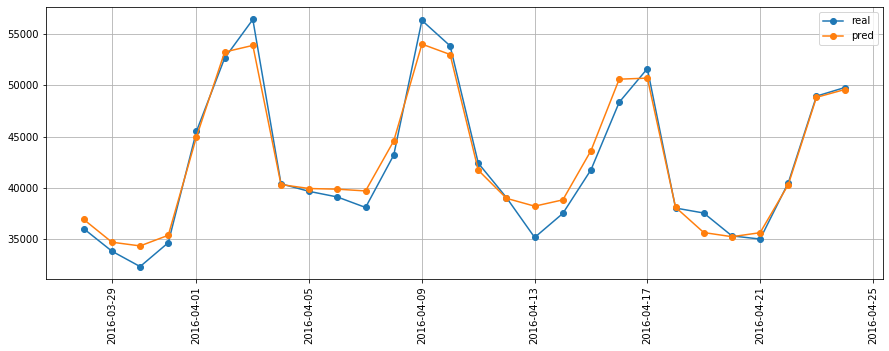

In [81]:
df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()

print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

***

In [82]:
org = data.loc[:, ["store_id","state_id"]].drop_duplicates()

In [83]:
df = (mrg
      .merge(org, how="left")
      .groupby(["ds","state_id"])["y","y_pred"]
      .sum()
      .reset_index())

In [84]:
df["sq_error"] = df.eval("(y-y_pred)**2")

rmsse = (df
         .groupby(["state_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level2, how="left", on=["state_id"])
         .merge(weights_level2, how="left", on=["state_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.3526857852539533


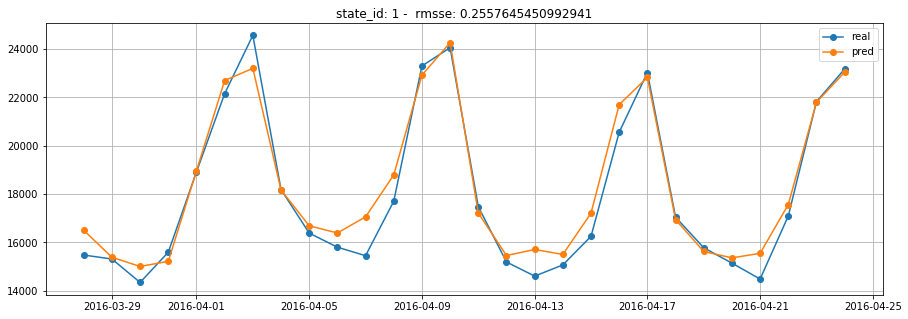

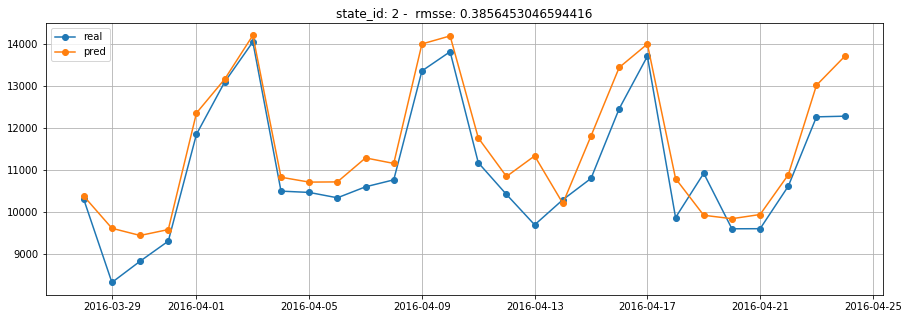

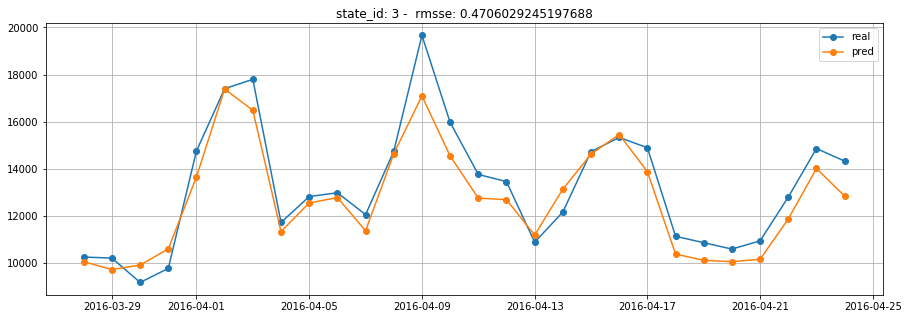

In [85]:
for state_id in [1,2,3]:    
    df_cut = df.query("state_id == @state_id")
    rmsse = np.sqrt(df_cut.eval("(y-y_pred)**2").mean()) / scales_level2.query("state_id == @state_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"state_id: {state_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***